# Lezione 3 aprile 2025

Valutazione di un regressore lineare

In [317]:
import numpy as np
from sklearn.datasets import fetch_openml
import torch

boston = fetch_openml(name="boston", version=1)

X = boston.data.to_numpy().astype(float)
Y = boston.target.to_numpy().astype(float)

np.random.seed(123)
torch.random.manual_seed(123)
idx = np.random.permutation(len(X))

X = X[idx]
Y = Y[idx]

X_training = torch.Tensor(X[50:])
Y_training = torch.Tensor(Y[50:])

X_testing = torch.Tensor(X[:50])
Y_testing = torch.Tensor(Y[:50])

/Users/vincenzovillanova/miniconda3/envs/ML_def/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [318]:
from torch import nn


class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        """Costruisce un regressore lineare.
        Input:
            in_size: numero di feature in input (es. 13)
            out_size: numero di elementi in output (es. 1)"""
        super(LinearRegressor, self).__init__()

        self.linear = nn.Linear(in_size, out_size)

    def forward(self, x):
        """Definisce come processare l'input x"""
        result = self.linear(x)

        return result

In [319]:
from torch.utils.tensorboard import SummaryWriter

lr = 0.01
epochs = 300

writer = SummaryWriter("logs/linear_regressor_1")

# normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training - means) / stds
X_testing_norm = (X_testing - means) / stds

reg = LinearRegressor(13, 1)
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(reg.parameters(), lr=lr)

for e in range(epochs):
    reg.train()
    output = reg(X_training_norm)
    l = criterion(output.view(-1), Y_training)

    writer.add_scalar("loss/train", l.item(), global_step=e)

    l.backward()

    optimizer.step()
    optimizer.zero_grad()

    reg.eval()

    with torch.set_grad_enabled(False):
        y_test = reg(X_testing_norm)
        l = criterion(y_test.view(-1), Y_testing)
        writer.add_scalar("loss/test", l.item(), global_step=e)

In [320]:
# Per prevenire le etichette sia per il training sia per il testset facciamo :

preds_training = reg(X_training_norm)
preds_testing = reg(X_testing_norm)

In [321]:
# Un modo per valutare il modello consiste nel calcolare MSE. Definiamo una funzione e usiamola per calcolare l'errore di test:


def MSE(predictions, gt):
    assert predictions.shape == gt.shape
    return ((predictions - gt) ** 2).mean()


# Quando chiamiamo MSE, facciamo reshape delle predizioni in modo tale da passare da [N x 1] a dimensione  di shape [1]
print(
    "Mean Squared Errore (MSE) di training {:0.2f}".format(
        MSE(preds_training.view(-1), Y_training)
    )
)
print(
    "Mean Squared Errore (MSE) di training {:0.2f}".format(
        MSE(preds_testing.view(-1), Y_testing)
    )
)

Mean Squared Errore (MSE) di training 20.52
Mean Squared Errore (MSE) di training 44.04


In [322]:
# Per eliminare gli errori al quadrato dell'MSE usiamo RMSE


def RMSE(predictions, gt):
    assert predictions.shape == gt.shape
    return ((predictions - gt) ** 2).mean() ** (0.5)


# Quando chiamiamo MSE, facciamo reshape delle predizioni in modo tale da passare da [N x 1] a dimensione  di shape [1]
print(
    "Root Mean Squared Errore (RMSE) di training {:0.2f}".format(
        RMSE(preds_training.view(-1), Y_training)
    )
)
print(
    "Root Mean Squared Errore (RMSE) di training {:0.2f}".format(
        RMSE(preds_testing.view(-1), Y_testing)
    )
)

Root Mean Squared Errore (RMSE) di training 4.53
Root Mean Squared Errore (RMSE) di training 6.64


In [323]:
# Un'altra misura di errore utilizzata è la Mean Absolute Error (MAE)
# che consiste nel calcolare le medie dei valori assoluti delle differenze tra valori predetti e valori di ground truth


def MAE(predictions, gt):
    assert predictions.shape == gt.shape
    return ((predictions - gt).abs()).mean()


# Quando chiamiamo MSE, facciamo reshape delle predizioni in modo tale da passare da [N x 1] a dimensione  di shape [1]
print(
    "Mean Absolute Error (MAE) di training {:0.2f}".format(
        MAE(preds_training.view(-1), Y_training)
    )
)
print(
    "Mean Absolute Error (MAE) di training {:0.2f}".format(
        MAE(preds_testing.view(-1), Y_testing)
    )
)

Mean Absolute Error (MAE) di training 3.08
Mean Absolute Error (MAE) di training 4.31


In [324]:
# REC Regression Error Curve

# Asse x: serie di solgie di tolleranza
# Asse y: percentuale degli elementi di test che presentano un errore inferiore o uguale all'errore corrispndente
# Area Over the Curve offre una misura dell'errore del metodo

import matplotlib.pyplot as plt


def REC_curve(predictions, gt):
    assert predictions.shape == gt.shape
    # Usiamo la Mean Absolute Error (MAE)
    errors = np.abs((predictions.detach().cpu().numpy()) - gt.cpu().numpy())
    # prendiamo i valori unici degli errori ed ordiniamoli
    tollerances = sorted(np.unique(errors))
    correct = []

    for t in tollerances:
        correct.append(
            (errors <= t).mean()
        )  # Frazione degli elementi correttamente regressi

    AUC = np.trapz(
        correct, tollerances
    )  # Area sotto la curva calcolata con il metodo dei trapezi
    tot_area = np.max(tollerances) * 1  # Area totale
    AOC = tot_area - AUC

    return tollerances, correct, AOC

# Spiegazione del codice

# 📈 REC Regression Error Curve – Spiegazione del Codice

```python
def REC_curve(predictions, gt):
```

Definisce una funzione che costruisce una **Regression Error Curve (REC)**, utile per valutare le prestazioni di un modello di **regressione**.

---

## 🔍 Cosa fa il codice?

### 1. **Controllo della forma**
```python
assert predictions.shape == gt.shape
```
Verifica che `predictions` e `gt` (ground truth) abbiano la stessa forma.

---

### 2. **Calcolo degli errori assoluti**
```python
errors = np.abs((predictions.detach().cpu().numpy()) - gt.cpu().numpy()) 
```
- Converte i tensori PyTorch in array NumPy.
- Calcola l’**errore assoluto** elemento per elemento.

| Funzione | Significato | Scopo |
|----------|-------------|-------|
| `detach()` | Stacca il tensore dal grafo dei gradienti | Serve per evitare il tracciamento dei gradienti |
| `cpu()` | Porta il tensore sulla CPU | Necessario prima di usare `.numpy()` |
| `numpy()` | Converte il tensore in array NumPy | Utile per usare le funzioni di NumPy |
| `-` | Differenza tra predizione e valore reale | Calcola l’errore (può essere negativo) |
| `np.abs(...)` | Valore assoluto dell’errore | Ottiene l’**errore assoluto** per ogni elemento |

---

### 3. **Tolleranze uniche ordinate**
```python
tollerances = sorted(np.unique(errors))
```
- Estrae i valori **unici** degli errori.
- Li ordina per usarli come soglie crescenti nella curva REC.

---

### 4. **Calcolo della frazione di errori sotto la soglia**
```python
correct = []

for t in tollerances:
    correct.append((errors <= t).mean())
```
- Per ogni soglia `t`, calcola la **percentuale** di predizioni che hanno errore ≤ `t`.

---

### 5. **Calcolo dell’area sotto e sopra la curva**
```python
AUC = np.trapezoid(correct, tollerances)
tot_area = np.max(tollerances) * 1
AOC = tot_area - AUC
```
- `AUC`: area sotto la curva, misura della **precisione del modello**.
- `AOC`: area sopra la curva, misura dell’**errore del modello**. Più è piccola, meglio è.

---

## ✅ Output della funzione

```python
return tollerances, correct, AOC
```

Restituisce:
- `tollerances`: soglie di tolleranza usate nell’analisi.
- `correct`: percentuali di predizioni corrette per ciascuna soglia.
- `AOC`: **Area Over the Curve**, misura complessiva dell’errore.

---

## 📊 Interpretazione della REC Curve

- **Asse x**: soglie di tolleranza (errore massimo accettabile).
- **Asse y**: percentuale di predizioni con errore ≤ soglia.
- Una curva che cresce più rapidamente indica un modello più accurato.
- Una **AOC più bassa** indica migliori prestazioni.

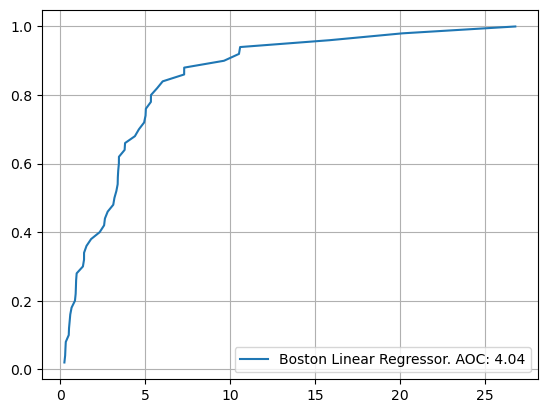

In [325]:
boston_linear_regression_rec = REC_curve(preds_testing.view(-1), Y_testing)
plt.plot(boston_linear_regression_rec[0], boston_linear_regression_rec[1])
plt.legend(["Boston Linear Regressor. AOC: %0.2f" % boston_linear_regression_rec[2]])
plt.grid()
plt.show()

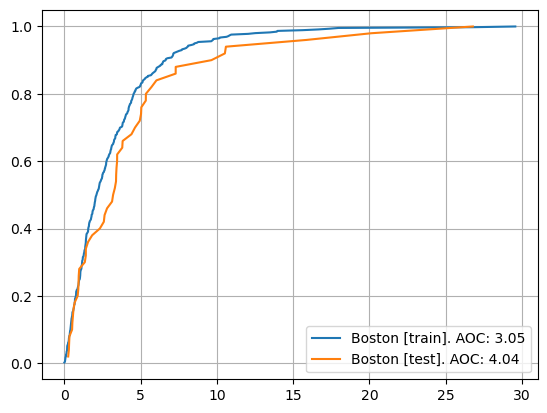

In [326]:
boston_linear_regression_training_rec = REC_curve(preds_training.view(-1), Y_training)
boston_linear_regression_testing_rec = REC_curve(preds_testing.view(-1), Y_testing)

plt.plot(
    boston_linear_regression_training_rec[0], boston_linear_regression_training_rec[1]
)
plt.plot(
    boston_linear_regression_testing_rec[0], boston_linear_regression_testing_rec[1]
)
plt.legend(
    [
        "Boston [train]. AOC: %0.2f" % boston_linear_regression_training_rec[2],
        "Boston [test]. AOC: %0.2f" % boston_linear_regression_testing_rec[2],
    ]
)
plt.grid()
plt.show()

# Regressione Logistica in PyTorch

In [327]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

print(X.shape)
print(Y.shape)
print(Y[:100])
print(dataset.DESCR)

(569, 30)
(569,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0]
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

  

## 📊 Contesto
Hai un dataset che contiene 569 esempi. Ogni esempio rappresenta una misurazione di un tessuto mammario con 30 caratteristiche (attributi) numerici che descrivono le proprietà del nucleo delle cellule. Ogni esempio è etichettato come:
- 1 → Il tumore è maligno (cancro presente)
- 0 → Il tumore è benigno (cancro assente)

### Obiettivo
Addestrare un modello che, dato un nuovo esempio, possa prevedere la probabilità che il tumore sia maligno → cioè la probabilità che l'etichetta sia 1.

---

## ⚠️ Problema con la regressione lineare

In una regressione lineare, si calcola un output così:

$$
z = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n
$$

dove:
- $ x_1, x_2, ..., x_n $ sono le caratteristiche dell’esempio
- $ \theta_0, ..., \theta_n $ sono i parametri (pesi) che il modello impara

Ma la regressione lineare produce un valore $ z $ che può essere qualunque numero reale, anche negativo o maggiore di 1. Questo è un problema, perché noi vogliamo stimare una probabilità, cioè un numero compreso tra 0 e 1.

---

## ✅ Soluzione: Regressione Logistica

La regressione logistica si basa su due concetti fondamentali:

### 1. Funzione logit
La funzione logit serve per trasformare una probabilità $ p $ in un numero reale:

$$
\text{logit}(p) = \ln\left( \frac{p}{1 - p} \right)
$$

> Questa funzione prende un numero tra 0 e 1 e lo trasforma in un numero che può andare da $ -\infty $ a $ +\infty $

### 2. Modello
In regressione logistica, si assume che:

$$
z = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n
$$

sia uguale alla logit della probabilità:

$$
z = \text{logit}(P(y = 1 | x))
$$

Ma noi vogliamo la probabilità, non la logit. Allora invertiamo la funzione logit → otteniamo la funzione sigmoide (o logistica):

---

## 🌀 Funzione logistica (sigmoide)

La funzione sigmoide è la funzione inversa del logit:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Questa funzione ha 3 proprietà fondamentali:
- Trasforma un numero reale in un numero tra 0 e 1
- Se $ z $ è molto positivo, $ \sigma(z) \approx 1 $
- Se $ z $ è molto negativo, $ \sigma(z) \approx 0 $

### Quindi:
$$
P(y = 1 | x) = \sigma(z) = \frac{1}{1 + e^{-(\theta_0 + \theta_1 x_1 + \dots + \theta_n x_n)}}
$$

---

## 🧠 Interpretazione del modello

Il modello dice: “dato un input $ x $, calcolo uno score $ z $, e poi lo trasformo in una probabilità che $ y = 1 $ usando la sigmoide”.

---

## ❌ Funzione di Loss (errore)

Per addestrare il modello, abbiamo bisogno di sapere quanto sbaglia.

Usiamo la log loss (o binary cross-entropy) come funzione di errore.

Per un singolo esempio:

$$
\mathcal{L}(z, y) = -y \log(\sigma(z)) - (1 - y) \log(1 - \sigma(z))
$$

> Dove:
- $ y \in \{0, 1\} $ è la vera etichetta
- $ \sigma(z) $ è la probabilità predetta

### Spiegazione:
- Se $ y = 1 $, la loss diventa $ -\log(\sigma(z)) $ → punisce fortemente se la probabilità predetta è bassa.
- Se $ y = 0 $, la loss diventa $ -\log(1 - \sigma(z)) $ → punisce fortemente se la probabilità predetta è alta.

---

## 🧮 Loss totale (su tutto il dataset)

Per tutti gli $ N $ esempi del dataset, la loss media è:

$$
\mathcal{L}_N(\theta) = \frac{1}{N} \sum_{i=1}^N \left[ -y_i \log(\sigma(z_i)) - (1 - y_i) \log(1 - \sigma(z_i)) \right]
$$

---

## 🔁 Addestramento del modello

L’addestramento consiste nel trovare i valori ottimali di $ \theta_0, \theta_1, ..., \theta_n $ che minimizzano la loss totale. Questo si fa con algoritmi come la discesa del gradiente.

---

## 📌 Riassunto finale


| Passaggio | Spiegazione |
|----------|-------------|
| 1. Input | Un vettore $ x $ con 30 caratteristiche |
| 2. Score | Calcolo $ z = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n $ |
| 3. Probabilità | Calcolo $ \sigma(z) = \frac{1}{1 + e^{-z}} $ |
| 4. Predizione | Se $ \sigma(z) > 0.5 $, prevedo 1; altrimenti 0 |
| 5. Errore | Uso la log-loss per calcolare quanto sbaglio |
| 6. Allenamento | Modifico $ \theta $ per minimizzare la loss |

---

In [328]:
np.random.seed(1234)
torch.random.manual_seed(1234)

In [329]:
idx = np.random.permutation(len(X))

X = X[idx]
Y = Y[idx]

In [330]:
# Suddividiamo il dataset in training e testing
X_training = torch.Tensor(X[100:])
Y_training = torch.Tensor(Y[100:])

X_testing = torch.Tensor(X[:100])
Y_testing = torch.Tensor(Y[:100])

In [331]:
# Normalizziamo i dati

X_mean = X_training.mean(0)
X_std = X_training.std(0)

X_training_norm = (X_training - X_mean) / X_std
X_testing_norm = (X_testing - X_mean) / X_std

In [332]:
linear_regressor = nn.Linear(30, 1)

In [333]:
z = linear_regressor(X_training_norm)
print(z[:10])

tensor([[-0.1096],
        [ 0.0380],
        [ 0.2178],
        [ 0.3410],
        [ 0.1903],
        [ 0.4142],
        [-0.0980],
        [-0.0238],
        [ 0.1587],
        [ 0.1500]], grad_fn=<SliceBackward0>)


In [334]:
print(z.min())
print(z.max())

tensor(-0.9687, grad_fn=<MinBackward1>)
tensor(1.2384, grad_fn=<MaxBackward1>)


In [335]:
def logistic(z):
    return 1.0 / (1 + torch.exp(-z))

In [336]:
p = logistic(z)
print(p[:10])

tensor([[0.4726],
        [0.5095],
        [0.5542],
        [0.5844],
        [0.5474],
        [0.6021],
        [0.4755],
        [0.4941],
        [0.5396],
        [0.5374]], grad_fn=<SliceBackward0>)


In [337]:
print(p.min())
print(p.max())

tensor(0.2751, grad_fn=<MinBackward1>)
tensor(0.7753, grad_fn=<MaxBackward1>)


In [338]:
# Modo alternativo offerto da Torch, si comporta allo stesso modo della funzione logistica implementata da noi

sigmoid = nn.Sigmoid()

In [339]:
p2 = sigmoid(z)
print(p2.min())
print(p2.max())

tensor(0.2751, grad_fn=<MinBackward1>)
tensor(0.7753, grad_fn=<MaxBackward1>)


In [340]:
def loss(p, y):
    return (-y * torch.log(p) - (1 - y) * torch.log(1 - p)).mean()

In [341]:
print(loss(p, Y_training.view(-1, 1)))

tensor(0.6579, grad_fn=<MeanBackward0>)


In [342]:
# Alternativa alla funzione di loss che abbiamo creato noi
loss = nn.BCELoss()

In [343]:
print(loss(p, Y_training.view(-1, 1)))

tensor(0.6579, grad_fn=<BinaryCrossEntropyBackward0>)


Adesso abbiamo tutti gli ingredienti che ci servono per allenare il regressore logistico. Effettuiamo il training utilizzando lo schema visto nel caso della regressione lineare:

1. Normalizzare i dati in ingresso $x$;
2. Inizializzare i parametri $\theta$ in maniera opportuna;
3. Calcolare i logit $\hat{z} = \sum_i (\theta_i x_i) + \theta_0$;
4. Calcolare le probabilità $p = \frac{1}{1 + e^{-\hat{z}}}$;
5. Calcolare il valore della loss $\mathcal{L}_\theta(p, y)$;
6. Calcolare il gradiente rispetto ai parametri $\theta$ della funzione di loss $\nabla_\theta \mathcal{L}_\theta(p, y)$;
7. Aggiornare i pesi $\theta$ secondo la regola: $\theta = \theta - \eta \nabla_\theta \mathcal{L}_\theta(p, y)$, dove $\eta$ è il learning rate;
8. Ripetere i passi 3–7 fino a convergenza.


# Domanda 1 

Quali sono le differenze tra questa procedura di training e quella vista nel caso della regressione lineare?

## Differenze tra regressione logistica e regressione lineare

### ✅ Somiglianze
1. **Preprocessing**:
   - Entrambe normalizzano i dati in ingresso $ x $.
2. **Parametri**:
   - Entrambe usano parametri $ \theta $ da apprendere e li inizializzano.
3. **Struttura del modello**:
   - Entrambe calcolano una combinazione lineare dei dati di input:  
     $ \hat{z} = \sum_i \theta_i x_i + \theta_0 $.
4. **Ottimizzazione**:
   - Entrambe usano **discesa del gradiente** per aggiornare i parametri.
5. **Loop di apprendimento**:
   - Entrambe ripetono il calcolo della loss e l’aggiornamento dei parametri fino a convergenza.

---

### ❌ Differenze principali

| Aspetto                | Regressione Lineare                                       | Regressione Logistica                                               |
|------------------------|-----------------------------------------------------------|----------------------------------------------------------------------|
| **Obiettivo**          | Prevedere un valore continuo $ \hat{y} \in \mathbb{R} $ | Prevedere una probabilità $ p \in [0, 1] $                         |
| **Funzione di output** | Nessuna (output = $ \hat{z} $)                          | Funzione sigmoide: $ p = \frac{1}{1 + e^{-\hat{z}}} $              |
| **Loss Function**      | **MSE**: $ \mathcal{L} = \frac{1}{2}(y - \hat{y})^2 $   | **Cross-Entropy**: $ \mathcal{L} = -[y \log p + (1 - y) \log(1 - p)] $ |
| **Tipo di problema**   | Regressione (output continuo)                             | Classificazione binaria (output discreto/probabilità)               |
| **Interpretazione**    | Output numerico diretto                                   | Output come probabilità della classe 1                               |

---

### 🔍 In sintesi

La **regressione lineare** si usa per stimare valori numerici, mentre la **regressione logistica** per stimare **probabilità di classi binarie**. Anche se la struttura dell’algoritmo è simile, cambiano:

- l’attivazione finale (sigmoide vs. identità),
- la funzione di loss (cross-entropy vs. MSE),
- e l’interpretazione dell’output (probabilità vs. valore continuo).


In [344]:
class LogisticRegressor(nn.Module):
    def __init__(self, in_features):
        """
        Costruttore del modello di regressione logistica.

        Args:
            in_features (int): Numero di feature in input (dimensione del vettore x).
        """
        # Richiamo al costruttore della classe base nn.Module
        # Questo è fondamentale per abilitare tutti i meccanismi interni di PyTorch,
        # come il tracciamento dei parametri e la costruzione del grafo computazionale.
        super(LogisticRegressor, self).__init__()

        # Definizione del layer lineare:
        # Si tratta di una trasformazione affine: y = xW^T + b
        # Output di dimensione 1, perché la regressione logistica restituisce una sola probabilità.
        self.linear = nn.Linear(in_features, 1)

        # Funzione di attivazione sigmoide, che trasforma i logit in probabilità [0,1]
        self.logistic = nn.Sigmoid()

    def forward(self, x):
        """
        Passaggio in avanti (forward pass) del modello.

        Args:
            x (Tensor): Batch di input (batch_size x in_features)

        Returns:
            Tensor: Batch di probabilità (batch_size x 1)
        """
        # Calcolo dei logit (valori grezzi prima della sigmoide)
        logits = self.linear(x)

        # Applicazione della funzione sigmoide ai logit per ottenere le probabilità
        return self.logistic(logits)

In [345]:
from torch.utils.tensorboard import SummaryWriter

# Inizializza un oggetto SummaryWriter per registrare i log per TensorBoard
writer = SummaryWriter("logs/logistic_regressor")

# Imposta il learning rate e il numero di epoche di training
lr = 0.01
epochs = 500

# -----------------------------
# Passo 1: normalizzazione dei dati
# -----------------------------

# Calcoliamo media e deviazione standard delle feature sul training set
means = X_training.mean(0)
stds = X_training.std(0)

# Applichiamo la normalizzazione z-score (standardizzazione)
X_training_norm = (X_training - means) / stds
X_testing_norm = (X_testing - means) / stds
# ⚠️ Importante: usiamo media e std del training anche sul test per coerenza

# -----------------------------
# Passo 2: inizializzazione del modello
# -----------------------------

# Creiamo un'istanza del nostro regressore logistico
# Supponiamo che il dataset abbia 30 feature in input
regressor = LogisticRegressor(30)

# Definiamo la funzione di loss: Binary Cross Entropy (per classificazione binaria)
loss = nn.BCELoss()

# Definiamo l’ottimizzatore: Stochastic Gradient Descent
sgd = torch.optim.SGD(regressor.parameters(), lr)

# -----------------------------
# Training loop
# -----------------------------
for e in range(epochs):
    regressor.train()  # Imposta il modello in modalità training (abilita dropout, batchnorm, ecc.)

    # Passo 3 & 4: calcoliamo i logit + probabilità tramite il modello
    p = regressor(X_training_norm)

    # Passo 5: calcoliamo il valore della loss rispetto ai target (ground truth)
    l = loss(p, Y_training.view(-1, 1))  # View serve a rendere Y compatibile con le dimensioni di output

    # Passo 6: calcolo del gradiente della loss rispetto a tutti i parametri
    l.backward()

    # Log del valore della loss per TensorBoard (training loss)
    writer.add_scalar('loss/train', l.item(), global_step=e)

    # Passo 7: aggiornamento dei pesi tramite SGD
    sgd.step()

    # Azzeriamo i gradienti per evitare l'accumulo nel prossimo step
    sgd.zero_grad()

    # -----------------------------
    # Valutazione su test set
    # -----------------------------
    regressor.eval()  # Imposta il modello in modalità evaluation (disabilita dropout, batchnorm, ecc.)
    with torch.set_grad_enabled(False):  # Disabilita il tracciamento dei gradienti (più efficiente)
        p = regressor(X_testing_norm)
        l = loss(p, Y_testing.view(-1, 1))  # Calcoliamo la loss anche sul test set
        writer.add_scalar('loss/test', l.item(), global_step=e)  # Log della test loss


# Domanda 2

Si evidenzino le differenze tra il codice mostrato e quello viato nel caso del regressore lineare

| **Aspetto**                  | **Regressione Logistica**                                                                | **Regressione Lineare**                                                         |
| ---------------------------- | ---------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| **Architettura del modello** | Usa `Sigmoid` per trasformare l’output in probabilità:<br>`self.logistic = nn.Sigmoid()` | Nessuna funzione di attivazione finale (output è continuo, non una probabilità) |
| **Funzione di loss**         | `nn.BCELoss()` (Binary Cross Entropy), adatta alla classificazione binaria               | `nn.MSELoss()` (Mean Squared Error), adatta alla regressione continua           |
| **Interpretazione output**   | `p = regressor(x)` dà **probabilità** di appartenere alla classe 1                       | `y_pred = regressor(x)` dà **valori numerici continui**                         |
| **Target (Y)**               | I target devono essere **binari** (es. 0 o 1)                                            | I target sono **numeri reali** (es. valori continui)                            |
| **Shape del target**         | `Y.view(-1,1)` per allineare con output sigmoide `[batch_size, 1]`                       | Spesso non serve reshape, oppure si fa `Y.view(-1, 1)` per coerenza             |
| **Uso del modello**          | Classificazione: soglia a 0.5 su output per decidere la classe (`p > 0.5 → classe 1`)    | Regressione: si interpreta direttamente il valore come stima del target         |
| **Valutazione del modello**  | Può includere **accuracy, precision, recall**, oltre alla loss                           | Si valutano **errori continui** (es. MSE, RMSE, MAE)                            |


In [346]:
# Iniziamo calcolando le predizioni del modelo dati i pesi allenati

p_test = regressor(X_testing_norm)
# Calcoliamo il valore della loss
print(loss(p_test, Y_testing.view(-1,1)))

tensor(0.1860, grad_fn=<BinaryCrossEntropyBackward0>)


In [347]:
prob_training = regressor(X_training_norm)
prob_testing = regressor(X_testing_norm)

pred_training = prob_training>=0.5
pred_testing = prob_testing>=0.5

print(pred_testing[:10])

tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False]])


In [348]:
def accuracy(pred, gt):
    """
    Calcola l'accuracy date e predizioni pred e le etichette di ground truth gt
    """
    correct = pred.view(-1)==gt.view(-1)
    
    return float(correct.sum())/len(correct) # Conta il numero di predizioni corrette e divide per il numero totale di predizioni

In [349]:
print("Accuracy di training: {:0.2f}".format(accuracy(pred_training, Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(pred_testing, Y_testing)))


Accuracy di training: 0.97
Accuracy di test: 0.93


# Domanda 4

Perché il classificatore funziona meglio sul training set che su test set?

Ottima domanda!

Il motivo per cui il **classificatore funziona meglio sul training set che sul test set** è legato a un fenomeno molto comune nel machine learning chiamato **overfitting**.

---

### 🎯 **Spiegazione**

Durante il training, il modello:

* vede **ripetutamente** gli stessi dati,
* e **ottimizza i suoi parametri** per minimizzare la loss **specificamente** su quei dati.

Questo significa che:

* Impara a **modellare molto bene (anche troppo)** le caratteristiche del training set,
* Ma potrebbe non generalizzare altrettanto bene ai **dati mai visti prima** (come quelli del test set).

---

### 🔍 **Cause comuni**

1. **Modello troppo complesso** rispetto alla quantità di dati → riesce a "memorizzare" anziché imparare.
2. **Rumore** nei dati di training → il modello impara anche pattern non utili.
3. **Pochi dati** → il modello non ha abbastanza varietà per imparare a generalizzare.
4. **Differenze di distribuzione** tra training e test set (dataset shift).

---

### 📊 **Effetti visibili**

* **Loss di training bassa**, ma **loss di test più alta**.
* **Accuracy di training alta**, ma **accuracy di test più bassa**.

---

### ✅ **Conclusione**

Il modello si adatta meglio ai dati su cui è stato addestrato, ma può fallire nel **generalizzare**. È per questo che funziona meglio sul training set.

Vuoi qualche strategia per ridurre l’overfitting?



# Domanda 5

Un classificatore ottiene una sola varia a 0.91 su un dataset di 189 elementi. Quanti elementi sono stati classificati correttamente? Quanti elementi non sono stati classificati correttamente?

Per rispondere alla domanda, usiamo il fatto che la **accuratezza (accuracy)** è la frazione di esempi classificati correttamente:

$$
\text{Accuracy} = \frac{\text{Elementi corretti}}{\text{Totale elementi}}
$$

### ✅ Dati:

* Accuracy = 0.91
* Totale elementi = 189

---

### 🔢 Calcolo:

**Elementi classificati correttamente:**

$$
189 \times 0.91 = 171.99 \approx 172
$$

**Elementi classificati **non** correttamente:**

$$
189 - 172 = 17
$$

---

### 📌 Risposta:

* ✅ **172 elementi** sono stati classificati correttamente.
* ❌ **17 elementi** non sono stati classificati correttamente.

In [350]:
from torch.utils.tensorboard import SummaryWriter

# Inizializza un oggetto SummaryWriter per registrare i log per TensorBoard
writer = SummaryWriter("logs/logistic_regressor_2")

# Imposta il learning rate e il numero di epoche di training
lr = 0.01
epochs = 500

# -----------------------------
# Passo 1: normalizzazione dei dati
# -----------------------------

# Calcoliamo media e deviazione standard delle feature sul training set
means = X_training.mean(0)
stds = X_training.std(0)

# Applichiamo la normalizzazione z-score (standardizzazione)
X_training_norm = (X_training - means) / stds
X_testing_norm = (X_testing - means) / stds
# ⚠️ Importante: usiamo media e std del training anche sul test per coerenza

# -----------------------------
# Passo 2: inizializzazione del modello
# -----------------------------

# Creiamo un'istanza del nostro regressore logistico
# Supponiamo che il dataset abbia 30 feature in input
regressor = LogisticRegressor(30)

# Definiamo la funzione di loss: Binary Cross Entropy (per classificazione binaria)
loss = nn.BCELoss()

# Definiamo l’ottimizzatore: Stochastic Gradient Descent
sgd = torch.optim.SGD(regressor.parameters(), lr)

# -----------------------------
# Training loop
# -----------------------------
for e in range(epochs):
    regressor.train()  # Imposta il modello in modalità training (abilita dropout, batchnorm, ecc.)

    # Passo 3 & 4: calcoliamo i logit + probabilità tramite il modello
    p = regressor(X_training_norm)

    # Passo 5: calcoliamo il valore della loss rispetto ai target (ground truth)
    l = loss(p, Y_training.view(-1, 1))  # View serve a rendere Y compatibile con le dimensioni di output

    # Passo 6: calcolo del gradiente della loss rispetto a tutti i parametri
    l.backward()

    # Log del valore della loss per TensorBoard (training loss)
    writer.add_scalar('loss/train', l.item(), global_step=e)

    # Passo 7: aggiornamento dei pesi tramite SGD
    sgd.step()

    # Azzeriamo i gradienti per evitare l'accumulo nel prossimo step
    sgd.zero_grad()

    writer.add_scalar('accuracy/train', accuracy(p>=0.5,Y_training),global_step=e)
    # -----------------------------
    # Valutazione su test set
    # -----------------------------
    regressor.eval()  # Imposta il modello in modalità evaluation (disabilita dropout, batchnorm, ecc.)
    with torch.set_grad_enabled(False):  # Disabilita il tracciamento dei gradienti (più efficiente)
        p = regressor(X_testing_norm)
        l = loss(p, Y_testing.view(-1, 1))  # Calcoliamo la loss anche sul test set
        writer.add_scalar('loss/test', l.item(), global_step=e)  # Log della test loss
        writer.add_scalar('accuracy/test', accuracy(p>=0.5,Y_testing),global_step=e)

# 2.1 Stabilità Numerica

Finora abbiamo utilizzato la loss:

$$
\mathcal{L}_\theta(z, y) = \frac{1}{N} \sum_i -y_i \log(p_i) - (1 - y_i) \log(1 - p_i) \tag{11}
$$

dove:

$$
p_i = \frac{1}{1 + e^{-z_i}} \tag{12}
$$

Questa loss può essere numericamente instabile in quanto, per valori di $z_i$ molto bassi, $e^{-z_i}$ sarà un numero molto alto e di conseguenza $p_i$ sarà molto piccolo. Se il valore di $p_i$ scende al di sotto della precisione della macchina (cioè va in underflow), esso verrà arrotondato a zero. A questo punto, all'interno della funzione di loss $\mathcal{L}$, il valore $y_i \log(p_i)$ restituirà un nan se $y_i = 1$.

Per evitare questi problemi, in genere si utilizza la loss definita a partire dai logit:

$$
\mathcal{L}_\theta(z, y) = \frac{1}{N} \sum_i y_i \log(1 + e^{-z_i}) + (1 - y_i) \log(1 + e^{z_i}) \tag{13}
$$

Notiamo che questa loss non soffre dei problemi discussi sopra. Per valori molto bassi di $z_i$, infatti $e^{-z_i}$ non comparirà, mentre il termine $1 + e^{-z_i}$ sarà almeno pari a 1 (per cui potremo sempre calcolarne il logaritmo). Possiamo dunque effettuare la procedura di training evitando di calcolare esplicitamente le probabilità $p_i$ e applicando la seconda loss direttamente ai logit $z_i$. Definiamo la loss:

### La cross-entropy per un singolo esempio è:

$$
\mathcal{L}(p, y) = -[y \log(p) + (1 - y) \log(1 - p)]
$$

* Il termine $\log(p)$ è negativo se $p < 1$
* Il termine $\log(1 - p)$ è negativo se $p > 0$

### Senza il segno meno:

La loss potrebbe risultare negativa, e noi vogliamo invece minimizzarla, non massimizzare qualcosa di negativo.

> Il segno meno trasforma quindi la log-probabilità in una quantità da minimizzare, mantenendo il concetto: più il modello è certo e corretto, più bassa sarà la loss.

In pratica:

* Se la predizione è perfetta ($p = y$), la loss sarà vicina a 0
* Se la predizione è completamente sbagliata ($p \ll 1$ quando $y = 1$), la loss sarà grande

Ti interessa anche vedere un esempio numerico per chiarire il concetto?

In [351]:
def loss2(z,y):
    return (y*torch.log(1+torch.exp(-z))+(1-y)*torch.log(1+torch.exp(z))).mean()

In [352]:
class LogisticRegressor(nn.Module):
    def __init__(self, in_features):
        super(LogisticRegressor, self).__init__()
        self.linear = nn.Linear(in_features, 1)
        self.logistic = nn.Sigmoid()

    def forward(self, x):
        logits = self.linear(x)
        return logits

In [353]:
regressor =LogisticRegressor(30)
logistic = nn.Sigmoid()

#logits
z = regressor(X_training_norm)
print(z.min(),z.max())

#probabilità
p = logistic(z)
print(p.min(),p.max())

tensor(-2.5596, grad_fn=<MinBackward1>) tensor(1.4102, grad_fn=<MaxBackward1>)
tensor(0.0718, grad_fn=<MinBackward1>) tensor(0.8038, grad_fn=<MaxBackward1>)


In [354]:
loss_stable = nn.BCEWithLogitsLoss()
l_1 = loss_stable(z,Y_training.view(-1,1))
l_2 = loss2(z,Y_training.view(-1,1))
print(l_1)
print(l_2)

tensor(0.8208, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.8208, grad_fn=<MeanBackward0>)


La procedura di training diventa dunque la seguente:

1. Normalizzare i dati in ingresso x;
2. Inizializzare i parametri $\theta$ in maniera opportuna;
3. Calcolare i logit $\hat{z} = \sum_i (\theta_i x_i) + \theta_0$;
4. Calcolare il valore della loss $\mathcal{L}_\theta(z, y)$;
5. Calcolare il gradiente rispetto ai parametri $\theta$ della funzione di loss $\nabla_\theta \mathcal{L}_\theta(z, y)$;
6. Aggiornare i pesi $\theta$ secondo la regola: $\theta = \theta - \eta \nabla_\theta \mathcal{L}_\theta(z, y)$, dove $\eta$ è il learning rate;
7. Ripetere i passi 3–6 fino a convergenza.

Modifichiamo il codice precedente per effettuare il training utilizzando la nuova loss:

In [355]:
from torch.utils.tensorboard import SummaryWriter

# Inizializza un oggetto SummaryWriter per registrare i log per TensorBoard
writer = SummaryWriter("logs/logistic_regressor_3")

# Imposta il learning rate e il numero di epoche di training
lr = 0.01
epochs = 500

# -----------------------------
# Passo 1: normalizzazione dei dati
# -----------------------------

# Calcoliamo media e deviazione standard delle feature sul training set
means = X_training.mean(0)
stds = X_training.std(0)

# Applichiamo la normalizzazione z-score (standardizzazione)
X_training_norm = (X_training - means) / stds
X_testing_norm = (X_testing - means) / stds
# ⚠️ Importante: usiamo media e std del training anche sul test per coerenza

# -----------------------------
# Passo 2: inizializzazione del modello
# -----------------------------

# Creiamo un'istanza del nostro regressore logistico
# Supponiamo che il dataset abbia 30 feature in input
regressor = LogisticRegressor(30)

# Definiamo la funzione di loss: Binary Cross Entropy (per classificazione binaria)
loss = nn.BCEWithLogitsLoss()

# Definiamo l’ottimizzatore: Stochastic Gradient Descent
sgd = torch.optim.SGD(regressor.parameters(), lr)

# -----------------------------
# Training loop
# -----------------------------
for e in range(epochs):
    regressor.train()  # Imposta il modello in modalità training (abilita dropout, batchnorm, ecc.)

    # Passo 3 & 4: calcoliamo i logit + probabilità tramite il modello
    z = regressor(X_training_norm)

    # Passo 5: calcoliamo il valore della loss rispetto ai target (ground truth)
    l = loss(z, Y_training.view(-1, 1))  # View serve a rendere Y compatibile con le dimensioni di output

    # Passo 6: calcolo del gradiente della loss rispetto a tutti i parametri
    l.backward()

    # Log del valore della loss per TensorBoard (training loss)
    writer.add_scalar('loss/train', l.item(), global_step=e)

    # Passo 7: aggiornamento dei pesi tramite SGD
    sgd.step()

    # Azzeriamo i gradienti per evitare l'accumulo nel prossimo step
    sgd.zero_grad()

    p=logistic(z)
    writer.add_scalar('accuracy/train', accuracy(p>=0.5,Y_training),global_step=e)
    # -----------------------------
    # Valutazione su test set
    # -----------------------------
    regressor.eval()  # Imposta il modello in modalità evaluation (disabilita dropout, batchnorm, ecc.)
    with torch.set_grad_enabled(False):  # Disabilita il tracciamento dei gradienti (più efficiente)
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1, 1))  # Calcoliamo la loss anche sul test set
        writer.add_scalar('loss/test', l.item(), global_step=e)  # Log della test loss
        p=logistic(z)
        writer.add_scalar('accuracy/test', accuracy(p>=0.5,Y_testing),global_step=e)

In [356]:
print("Accuracy di training: {:0.2f}".format(accuracy(logistic(regressor(X_training_norm))>=0.5,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(logistic(regressor(X_testing_norm))>=0.5,Y_testing)))

Accuracy di training: 0.97
Accuracy di test: 0.93
